# **1. Khởi tạo Spark**

In [1]:
!pip install seaborn matplotlib

     |████████████████████████████████| 10.3 MB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 766 kB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 27.4 MB 128 kB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os 
kafka = "org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.1"
spark = "org.apache.spark:spark-streaming-kafka-0-8_2.11:2.1.0"

os.environ["PYSPARK_SUBMIT_ARGS"] = ("--packages {},{} pyspark-shell".format(kafka, spark))
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
# from pyspark.sql.functions import to_json, struct, lit
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as func
sc = SparkContext('local')
spark = SparkSession(sc)
# spark = SparkSession \
#         .builder \
#         .master("spark://spark-master:7077") \
#         .appName("customer-segment") \
#         .getOrCreate()

# **2. Đọc dữ liệu**

In [3]:

df=spark.read.format('csv').options(header='true').option("inferSchema", "true")\
    .load("hdfs://namenode/user/taipt/data.csv")

In [4]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [5]:
df.show(10)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|12/1/2010 8:26|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|12/1/2010 8:26|     4.

# **3. Tiền xử lí dữ liệu và tính toán các chỉ số RFM**

In [6]:
df_initial = df.toPandas()

# Thống kê các trường dữ liệu null

In [7]:
from pandas import pandas as pd
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int32,datetime64[ns],float64,float64,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


In [8]:
visual_info = tab_info.T
del visual_info['column type']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Legend does not support <AxesSubplot:> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_path()


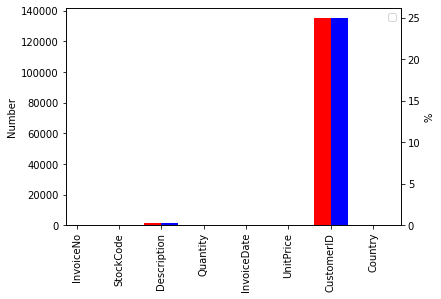

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()

width = 0.4

number_values = visual_info['null values (nb)'].plot(kind='bar', color='red', ax=ax, width=width, position=1, label='Number')
persent_values = visual_info['null values (%)'].plot(kind='bar', color='blue', ax=ax2, width=width, position=0, label='Percent')
plt.legend(handles=[number_values, persent_values])

ax.set_ylabel('Number')
ax2.set_ylabel('%')

plt.show()

# Thống kê số bản ghi trùng lặp

In [10]:
print('Số bản ghi trùng lặp: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Số bản ghi trùng lặp: 5268


In [11]:
df.groupBy("Country") \
    .count().orderBy(col("count").asc()).show()

+--------------------+-----+
|             Country|count|
+--------------------+-----+
|        Saudi Arabia|   10|
|             Bahrain|   19|
|      Czech Republic|   30|
|              Brazil|   32|
|           Lithuania|   35|
|             Lebanon|   45|
|                 RSA|   58|
|  European Community|   61|
|United Arab Emirates|   68|
|               Malta|  127|
|              Greece|  146|
|              Canada|  151|
|             Iceland|  182|
|           Singapore|  229|
|           Hong Kong|  288|
|                 USA|  291|
|              Israel|  297|
|              Poland|  341|
|               Japan|  358|
|             Denmark|  389|
+--------------------+-----+
only showing top 20 rows



# Xóa bản ghi trùng lặp 

In [12]:
df = df.na.drop().dropDuplicates()

In [13]:
df_country=df.groupBy("Country") \
    .count()

In [14]:
df_country=df.toPandas()

# Số  lượng khách hàng theo country

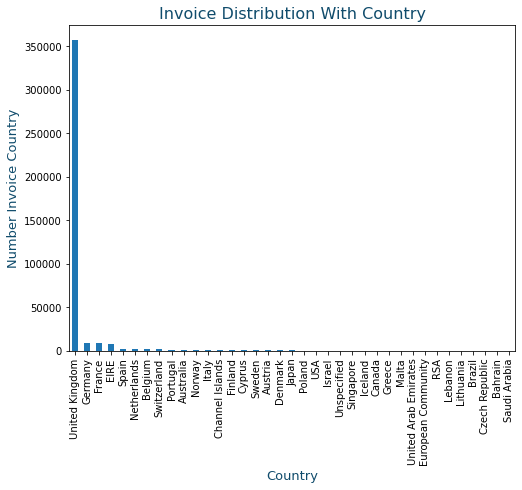

In [15]:
# Number of customers per cluster
import matplotlib.pyplot as plt
font_title = {
        'color':  '#104C6C',
        'weight': 'normal',
        'size': 16,
        }


font_label = {
        'color':  '#104C6C',
        'weight': 'normal',
        'size': 13,
        }
plt.figure(figsize=(8,6))
ax = df_country['Country'].value_counts().plot(kind='bar')
ax.set_ylabel('Number Invoice Country',font_label)
ax.set_xlabel('Country',font_label)
ax.set_title("Invoice Distribution With Country",font_title)
plt.show()

In [16]:
df=df.withColumn('TotalPrice',col('UnitPrice')*col('Quantity'))

In [17]:
df.show(3)

+---------+---------+--------------------+--------+---------------+---------+----------+--------------+----------+
|InvoiceNo|StockCode|         Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|TotalPrice|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+----------+
|   536367|    84879|ASSORTED COLOUR B...|      32| 12/1/2010 8:34|     1.69|     13047|United Kingdom|     54.08|
|   536392|    21891|TRADITIONAL WOODE...|      12|12/1/2010 10:29|     1.25|     13705|United Kingdom|      15.0|
|   536464|   85231B|CINAMMON SET OF 9...|       3|12/1/2010 12:23|     0.85|     17968|United Kingdom|      2.55|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+----------+
only showing top 3 rows



# Tính toán các giá trị RFM

In [18]:
df_totalByCountry=df.groupBy("Country").agg(func.sum("TotalPrice"))

In [19]:
df_totalByCountry.show(10)
df_affter=df 

+------------------+------------------+
|           Country|   sum(TotalPrice)|
+------------------+------------------+
|            Sweden|          36585.41|
|         Singapore|           9120.39|
|           Germany|221509.46999999997|
|               RSA|1002.3100000000001|
|            France|196626.05000000002|
|            Greece| 4710.519999999998|
|European Community|1291.7500000000005|
|           Belgium| 40910.95999999999|
|           Finland|22326.739999999987|
|             Malta|2505.4700000000003|
+------------------+------------------+
only showing top 10 rows



In [20]:
df_affter.show()

+---------+---------+--------------------+--------+---------------+---------+----------+--------------+------------------+
|InvoiceNo|StockCode|         Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|        TotalPrice|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+------------------+
|   536367|    84879|ASSORTED COLOUR B...|      32| 12/1/2010 8:34|     1.69|     13047|United Kingdom|             54.08|
|   536392|    21891|TRADITIONAL WOODE...|      12|12/1/2010 10:29|     1.25|     13705|United Kingdom|              15.0|
|   536464|   85231B|CINAMMON SET OF 9...|       3|12/1/2010 12:23|     0.85|     17968|United Kingdom|              2.55|
|   536520|    22553|PLASTERS IN TIN S...|       1|12/1/2010 12:43|     1.65|     14729|United Kingdom|              1.65|
|   536537|    20867|PINK ROSE FABRIC ...|      36|12/1/2010 13:51|     1.25|     15922|United Kingdom|              45.0|
|   536607|    2

In [21]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")
df_affter=df.withColumn('InvoiceDate',to_timestamp("InvoiceDate", "MM/dd/yyyy HH:mm"))

In [22]:
df_affter.show(10)
df=df_affter

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|        TotalPrice|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|   536367|    84879|ASSORTED COLOUR B...|      32|2010-12-01 08:34:00|     1.69|     13047|United Kingdom|             54.08|
|   536392|    21891|TRADITIONAL WOODE...|      12|2010-12-01 10:29:00|     1.25|     13705|United Kingdom|              15.0|
|   536464|   85231B|CINAMMON SET OF 9...|       3|2010-12-01 12:23:00|     0.85|     17968|United Kingdom|              2.55|
|   536520|    22553|PLASTERS IN TIN S...|       1|2010-12-01 12:43:00|     1.65|     14729|United Kingdom|              1.65|
|   536537|    20867|PINK ROSE FABRIC ...|      36|2010-12-01 13:51:00|     1.25|     15922|United Kingdom|    

In [23]:
import datetime as dt
today = dt.datetime(2012,1,1)
print(today)

2012-01-01 00:00:00


In [24]:
df = df[df['Quantity'] > 0]
df = df[df['TotalPrice'] > 0]
df = df[df["Country"] == "United Kingdom"]
df.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|        TotalPrice|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|   536367|    84879|ASSORTED COLOUR B...|      32|2010-12-01 08:34:00|     1.69|     13047|United Kingdom|             54.08|
|   536392|    21891|TRADITIONAL WOODE...|      12|2010-12-01 10:29:00|     1.25|     13705|United Kingdom|              15.0|
|   536464|   85231B|CINAMMON SET OF 9...|       3|2010-12-01 12:23:00|     0.85|     17968|United Kingdom|              2.55|
|   536520|    22553|PLASTERS IN TIN S...|       1|2010-12-01 12:43:00|     1.65|     14729|United Kingdom|              1.65|
|   536537|    20867|PINK ROSE FABRIC ...|      36|2010-12-01 13:51:00|     1.25|     15922|United Kingdom|    

# Tính giá trị R, M 

In [25]:
df.createOrReplaceTempView("dfTable")
df_x=spark.sql('SELECT CustomerID,sum(TotalPrice) as Monetary,(DATEDIFF( now(), max(InvoiceDate))) as Recency from dfTable GROUP BY CustomerID ORDER BY CustomerID')

In [26]:
df_x.show()

+----------+------------------+-------+
|CustomerID|          Monetary|Recency|
+----------+------------------+-------+
|     12346|           77183.6|   3795|
|     12747| 4196.010000000001|   3472|
|     12748|33053.189999999995|   3470|
|     12749|           4090.88|   3473|
|     12820|            942.34|   3473|
|     12821|             92.72|   3684|
|     12822|            948.88|   3540|
|     12823|            1759.5|   3544|
|     12824|397.11999999999995|   3529|
|     12826|1474.7199999999998|   3472|
|     12827|            430.15|   3475|
|     12828|           1018.71|   3472|
|     12829|293.00000000000006|   3806|
|     12830| 6814.640000000001|   3507|
|     12831|215.04999999999998|   3732|
|     12832|            383.03|   3502|
|     12833|            417.38|   3615|
|     12834|            312.38|   3752|
|     12836|2610.3599999999997|   3529|
|     12837|             134.1|   3643|
+----------+------------------+-------+
only showing top 20 rows



In [27]:
df_y=spark.sql('SELECT CustomerID,InvoiceNo,sum(TotalPrice) as TotalPrice from dfTable GROUP BY CustomerID,InvoiceNo ORDER BY CustomerID,InvoiceNo')

In [28]:
df_y.show()

+----------+---------+------------------+
|CustomerID|InvoiceNo|        TotalPrice|
+----------+---------+------------------+
|     12346|   541431|           77183.6|
|     12747|   537215|358.55999999999995|
|     12747|   538537|            347.71|
|     12747|   541677|303.03999999999996|
|     12747|   545321|            310.78|
|     12747|   551992|442.96000000000004|
|     12747|   554549|328.34999999999997|
|     12747|   558265|             376.3|
|     12747|   563949|             301.7|
|     12747|   569397| 675.3800000000001|
|     12747|   577104|            312.73|
|     12747|   581163|             438.5|
|     12748|   536521|              4.95|
|     12748|   536641|              4.25|
|     12748|   537136| 267.4599999999999|
|     12748|   537140| 65.57000000000001|
|     12748|   537142|             41.45|
|     12748|   537155|             73.72|
|     12748|   537213| 8.649999999999999|
|     12748|   537225|            491.38|
+----------+---------+------------

# Tính giá trị F

In [29]:
from pyspark.sql.functions import count
df_z=df_y.groupBy("CustomerID").agg(
count("TotalPrice").alias("Frequency"))

In [30]:
df_z.show()

+----------+---------+
|CustomerID|Frequency|
+----------+---------+
|     15619|        1|
|     17389|       34|
|     14450|        3|
|     15727|        7|
|     15790|        1|
|     13285|        4|
|     14570|        2|
|     16574|        1|
|     13832|        1|
|     13623|        5|
|     15957|        1|
|     16503|        4|
|     17679|        2|
|     17420|        3|
|     15447|        1|
|     16386|        2|
|     18024|        2|
|     16861|        2|
|     16339|        1|
|     12940|        2|
+----------+---------+
only showing top 20 rows



# Bảng kết quả R, F, M

In [31]:
# RFM Dataframe
rfm_table = df_x.join(df_z, ['CustomerID'])
rfm_table.show()

+----------+------------------+-------+---------+
|CustomerID|          Monetary|Recency|Frequency|
+----------+------------------+-------+---------+
|     15727|5159.0599999999995|   3486|        7|
|     13285| 2709.120000000001|   3493|        4|
|     17679|           1992.11|   3522|        2|
|     17389| 31833.68000000001|   3470|       34|
|     12940| 899.6899999999997|   3524|        2|
|     13623|            727.74|   3500|        5|
|     16574| 451.4399999999999|   3541|        1|
|     15957|            428.89|   3501|        1|
|     15790|218.74999999999997|   3480|        1|
|     16503|           1431.93|   3576|        4|
|     14570|218.05999999999995|   3750|        2|
|     17420| 598.8299999999999|   3520|        3|
|     16386| 302.5699999999999|   3498|        2|
|     14450|483.25000000000006|   3650|        3|
|     16339| 94.05000000000001|   3754|        1|
|     15619|336.40000000000003|   3480|        1|
|     16861|173.76000000000002|   3529|        2|


In [32]:
rfm_table.select('*').where("CustomerID=15727").show()

+----------+------------------+-------+---------+
|CustomerID|          Monetary|Recency|Frequency|
+----------+------------------+-------+---------+
|     15727|5159.0599999999995|   3486|        7|
+----------+------------------+-------+---------+



In [33]:
rfm_table.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Monetary: double (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- Frequency: long (nullable = false)



In [34]:
rfm_table_pandas=rfm_table.toPandas()

## Loại bỏ ngoại lai

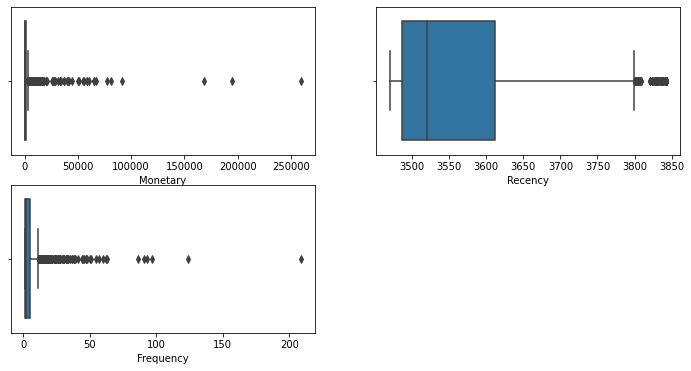

In [35]:
from scipy.stats import norm
import seaborn as sns
num_features = rfm_table_pandas.columns[1:]
r = c = 0
fig,ax = plt.subplots(2,2,figsize=(12,6))

for n,i in enumerate(num_features):
    sns.boxplot(x=i, data=rfm_table_pandas,ax=ax[r,c])
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

Dựa trên các Boxplots ở trên, có thể thấy rằng các thuộc tính Monetary và Frequency có các điểm outlier. Vì các thuật toán phân cụm như K-means dễ bị ảnh hưởng bởi các outlier, chúng em sẽ xử lý chúng bằng cách giới hạn chúng ở 95% lượng tử

In [36]:
h_cap = 0.95
h_cap_val = rfm_table_pandas['Monetary'].quantile(h_cap)
rfm_table_pandas['Monetary'][rfm_table_pandas['Monetary'] > h_cap_val] = h_cap_val
l_cap = 0.05
l_cap_val = rfm_table_pandas['Monetary'].quantile(l_cap)
rfm_table_pandas['Monetary'][rfm_table_pandas['Monetary'] < l_cap_val] = l_cap_val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
cap = 0.95
cap_val = rfm_table_pandas['Frequency'].quantile(cap)
rfm_table_pandas['Frequency'][rfm_table_pandas['Frequency'] > cap_val] = cap_val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


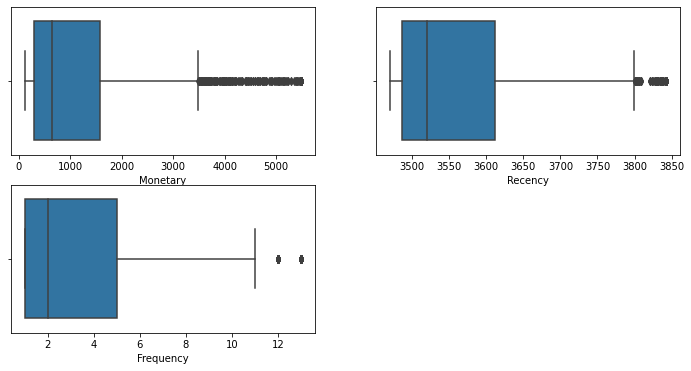

In [38]:
num_features = rfm_table_pandas.columns[1:]
r = c = 0
fig,ax = plt.subplots(2,2,figsize=(12,6))

for n,i in enumerate(num_features):
    sns.boxplot(x=i, data=rfm_table_pandas,ax=ax[r,c])
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

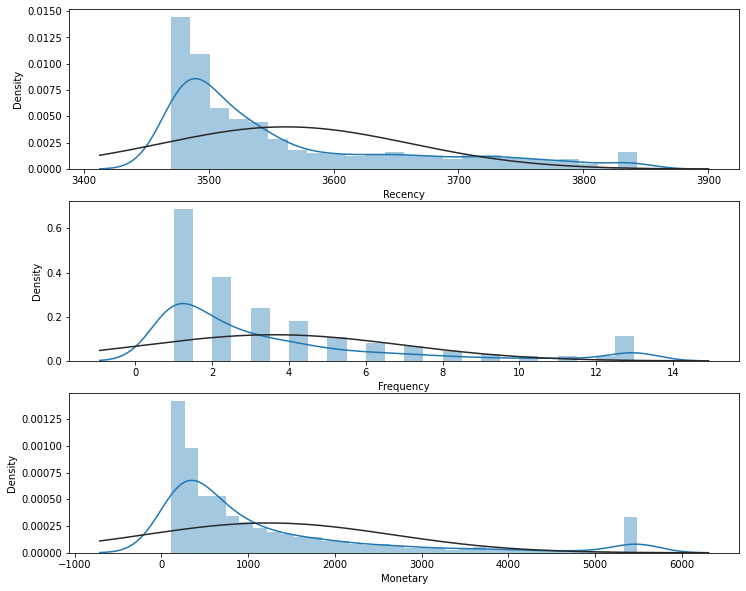

In [39]:
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm_table_pandas['Recency'],fit=norm)
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm_table_pandas['Frequency'],fit=norm)
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm_table_pandas['Monetary'],fit=norm)
# Show the plot
plt.show()


## Normalization


In [40]:
clustering_fm=spark.createDataFrame(rfm_table_pandas)

In [41]:
clustering_fm.printSchema()

root
 |-- CustomerID: long (nullable = true)
 |-- Monetary: double (nullable = true)
 |-- Recency: long (nullable = true)
 |-- Frequency: long (nullable = true)



In [42]:
from pyspark.ml.feature import StandardScaler,VectorAssembler
from pyspark.ml import Pipeline 

columns_to_scale = ["Monetary", "Recency", "Frequency"]
assemblers = VectorAssembler(inputCols= ["Monetary", "Recency", "Frequency"], outputCol='feature' )
scaler=StandardScaler(inputCol='feature',outputCol='standardized')
pipeline = Pipeline(stages=[assemblers,scaler])
scalerModel = pipeline.fit(clustering_fm)
scaledData = scalerModel.transform(clustering_fm)

In [43]:
scaledData.show()

+----------+------------------+-------+---------+--------------------+--------------------+
|CustomerID|          Monetary|Recency|Frequency|             feature|        standardized|
+----------+------------------+-------+---------+--------------------+--------------------+
|     15727|5159.0599999999995|   3486|        7|[5159.05999999999...|[3.61046186923256...|
|     13285| 2709.120000000001|   3493|        4|[2709.12000000000...|[1.89592182668457...|
|     17679|           1992.11|   3522|        2|[1992.11,3522.0,2.0]|[1.39413714791393...|
|     17389| 5488.443999999999|   3470|       13|[5488.44399999999...|[3.84097447663299...|
|     12940| 899.6899999999997|   3524|        2|[899.689999999999...|[0.62962951373502...|
|     13623|            727.74|   3500|        5| [727.74,3500.0,5.0]|[0.50929384824276...|
|     16574| 451.4399999999999|   3541|        1|[451.439999999999...|[0.31593098476201...|
|     15957|            428.89|   3501|        1| [428.89,3501.0,1.0]|[0.3001498

In [44]:
data_scaled=scaledData.select("CustomerID","standardized","Monetary","Recency","Frequency")

In [45]:
feature=data_scaled.select("standardized")

# **4. Phân cụm khách hàng sử dụng K-Means**

## **a) Tìm giá trị tối ưu của số cụm K**

## Elbow Method

In [46]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

In [47]:
wscc = []
for i in range(2,15):
    kmeans = KMeans(featuresCol='standardized',k=i,maxIter=10)
    kmeans.setSeed(1)
    model = kmeans.fit(data_scaled)
    wscc.append(model.summary.trainingCost)


Text(0.5, 1.0, 'Elbow plot for optimal number of clusters')

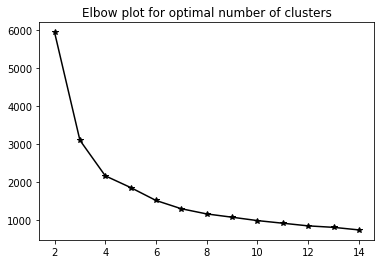

In [48]:
plt.plot(range(2,15),wscc,marker="*",c="black")
plt.title("Elbow plot for optimal number of clusters")

## Silhouette Analysis


In [49]:
wscc = []
for i in range(2,15):
    kmeans = KMeans(featuresCol='standardized',k=i,maxIter=10)
    kmeans.setSeed(1)
    model = kmeans.fit(data_scaled)
    predictions = model.transform(data_scaled)
    evaluator = ClusteringEvaluator(featuresCol='standardized')
    silhouette = evaluator.evaluate(predictions)
    wscc.append(silhouette)

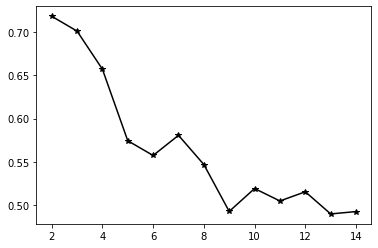

In [50]:
plt.plot(range(2,15),wscc,marker="*",c="black")

## **b)Áp dụng thuật toán K-Mean với số cụm k=3**

In [51]:
kmeans = KMeans(featuresCol='standardized',k=3,maxIter=10)
kmeans.setSeed(1)
model = kmeans.fit(data_scaled)

# Make predictions
predictions = model.transform(data_scaled)

In [52]:
labels = [p.prediction for p in predictions ]

In [53]:
predictions.show()

+----------+--------------------+------------------+-------+---------+----------+
|CustomerID|        standardized|          Monetary|Recency|Frequency|prediction|
+----------+--------------------+------------------+-------+---------+----------+
|     15727|[3.61046186923256...|5159.0599999999995|   3486|        7|         1|
|     13285|[1.89592182668457...| 2709.120000000001|   3493|        4|         0|
|     17679|[1.39413714791393...|           1992.11|   3522|        2|         0|
|     17389|[3.84097447663299...| 5488.443999999999|   3470|       13|         1|
|     12940|[0.62962951373502...| 899.6899999999997|   3524|        2|         0|
|     13623|[0.50929384824276...|            727.74|   3500|        5|         0|
|     16574|[0.31593098476201...| 451.4399999999999|   3541|        1|         0|
|     15957|[0.30014983177073...|            428.89|   3501|        1|         0|
|     15790|[0.15308768145643...|218.74999999999997|   3480|        1|         0|
|     16503|[1.0

In [54]:
df_clustered=df.join(predictions, ['CustomerID']).select('CustomerID',"InvoiceNo","Description","prediction")

In [55]:
df_clustered.show()

+----------+---------+--------------------+----------+
|CustomerID|InvoiceNo|         Description|prediction|
+----------+---------+--------------------+----------+
|     13098|   555836|WATERING CAN GREE...|         1|
|     13098|   570275|WALL ART CLASSIC ...|         1|
|     13098|   581410|VINTAGE DOILY JUM...|         1|
|     13098|   555836|WRAP VINTAGE PETA...|         1|
|     13098|   557900|SET OF 72 RETROSP...|         1|
|     13098|   560854|LUNCH BAG DOILEY ...|         1|
|     13098|   570268|JUMBO BAG VINTAGE...|         1|
|     13098|   557067|LUNCH BAG DOILEY ...|         1|
|     13098|   570268|BOX OF 6 MINI VIN...|         1|
|     13098|   570275|GLASS APOTHECARY ...|         1|
|     13098|   573143|BOX OF 24 COCKTAI...|         1|
|     13098|   552547|HANGING JAM JAR T...|         1|
|     13098|   552710|ASSORTED COLOURS ...|         1|
|     13098|   562282|TEA PARTY  WRAPPI...|         1|
|     13098|   573143| RED RETROSPOT WRAP |         1|
|     1309

In [56]:
df_clustered.show()

+----------+---------+--------------------+----------+
|CustomerID|InvoiceNo|         Description|prediction|
+----------+---------+--------------------+----------+
|     13098|   555836|WATERING CAN GREE...|         1|
|     13098|   570275|WALL ART CLASSIC ...|         1|
|     13098|   581410|VINTAGE DOILY JUM...|         1|
|     13098|   555836|WRAP VINTAGE PETA...|         1|
|     13098|   557900|SET OF 72 RETROSP...|         1|
|     13098|   560854|LUNCH BAG DOILEY ...|         1|
|     13098|   570268|JUMBO BAG VINTAGE...|         1|
|     13098|   557067|LUNCH BAG DOILEY ...|         1|
|     13098|   570268|BOX OF 6 MINI VIN...|         1|
|     13098|   570275|GLASS APOTHECARY ...|         1|
|     13098|   573143|BOX OF 24 COCKTAI...|         1|
|     13098|   552547|HANGING JAM JAR T...|         1|
|     13098|   552710|ASSORTED COLOURS ...|         1|
|     13098|   562282|TEA PARTY  WRAPPI...|         1|
|     13098|   573143| RED RETROSPOT WRAP |         1|
|     1309

## **c)Phân tích và gán nhãn cụm**

In [57]:
 rfm_table_pre_pandas=predictions.select("prediction","Monetary","Recency","Frequency").toPandas()

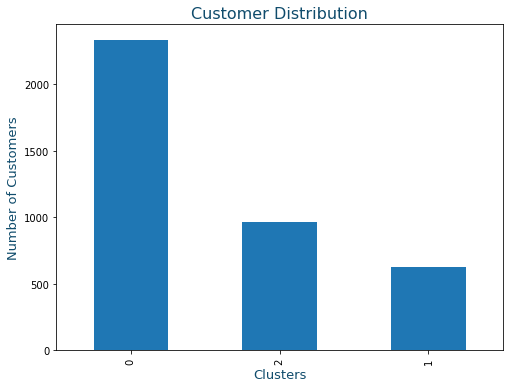

In [58]:
# Number of customers per cluster

font_title = {
        'color':  '#104C6C',
        'weight': 'normal',
        'size': 16,
        }


font_label = {
        'color':  '#104C6C',
        'weight': 'normal',
        'size': 13,
        }
plt.figure(figsize=(8,6))
ax = rfm_table_pre_pandas['prediction'].value_counts().plot(kind='bar')
ax.set_ylabel('Number of Customers',font_label)
ax.set_xlabel('Clusters',font_label)
ax.set_title("Customer Distribution",font_title)
plt.show()

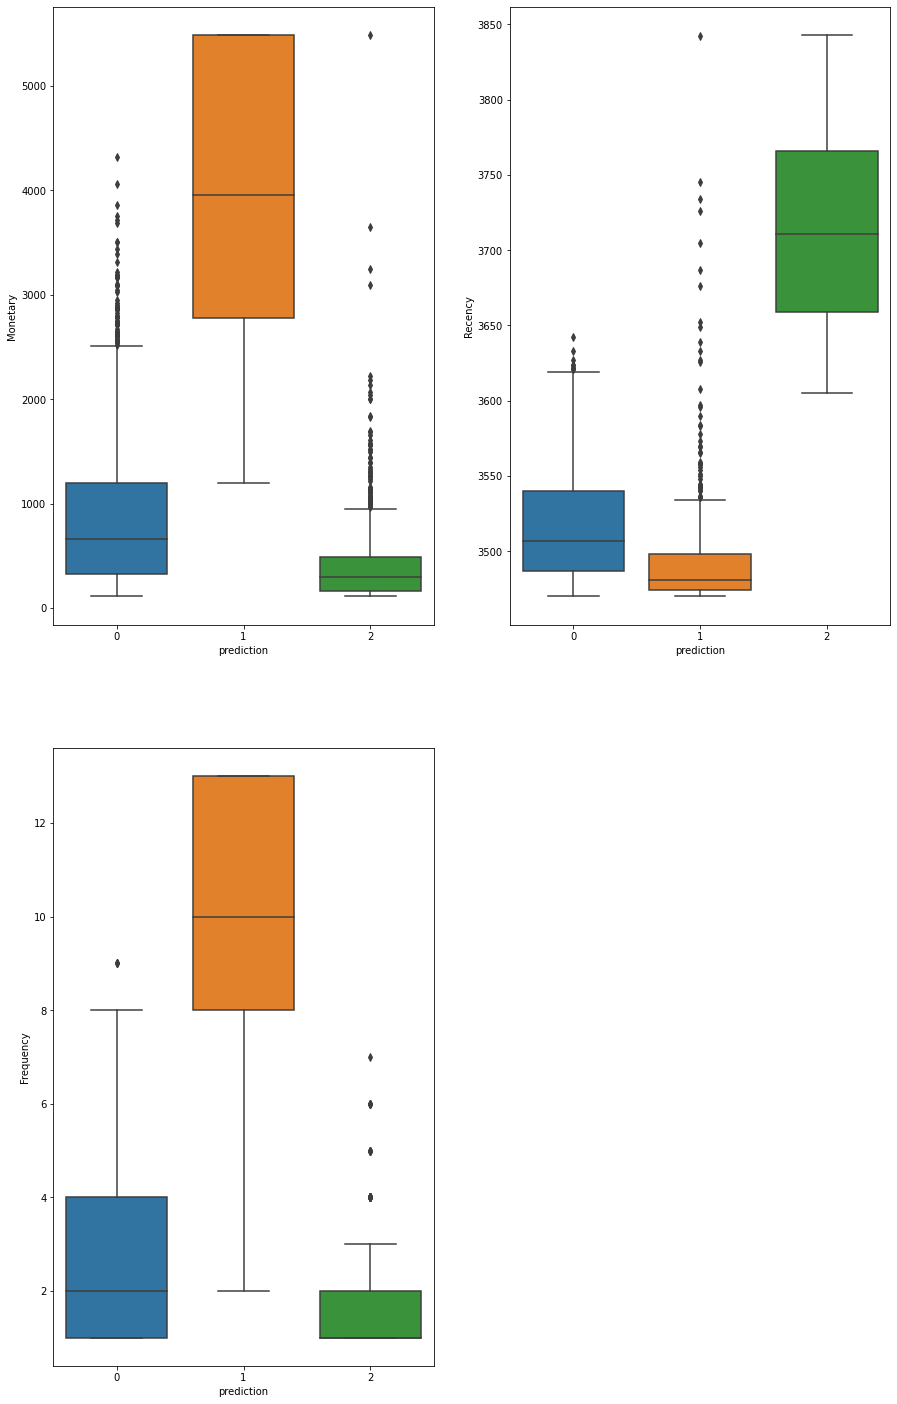

In [59]:
# Visualizing Numerical columns using Boxplots
cols = rfm_table_pre_pandas.columns[1:].tolist()
r = c = 0
fig,ax = plt.subplots(2,2,figsize=(15,25))

for n,i in enumerate(cols):
    sns.boxplot(x='prediction',y=cols[n], data=rfm_table_pre_pandas,ax=ax[r,c])
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

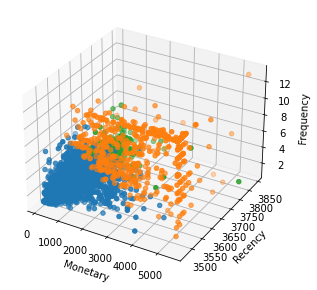

In [60]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for i in range(5):
    rfm_table_pre_0=predictions.select("*").where("prediction = "+str(i)).toPandas()
    ax.scatter(rfm_table_pre_0.Monetary,rfm_table_pre_0.Recency,rfm_table_pre_0.Frequency, marker='o')

ax.set_xlabel('Monetary')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')

plt.show()

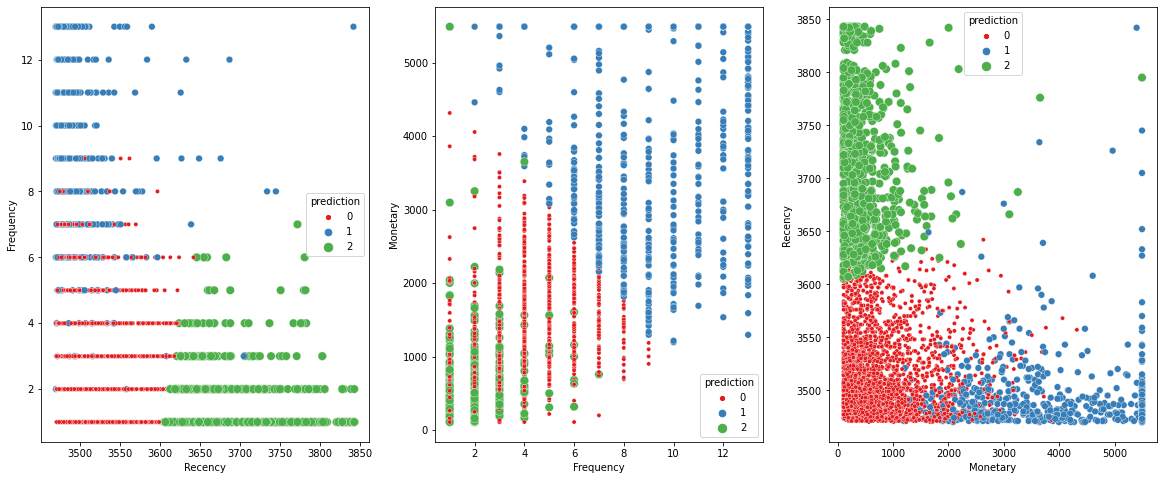

In [61]:
fig = plt.figure(figsize=[20,8])

plt.subplot(1,3,1)
sns.scatterplot(data=rfm_table_pre_pandas,x="Recency",y="Frequency",hue="prediction",size="prediction",palette="Set1")
plt.subplot(1,3,2)
sns.scatterplot(data=rfm_table_pre_pandas,x="Frequency",y="Monetary",hue="prediction",size="prediction",palette="Set1")
plt.subplot(1,3,3)
sns.scatterplot(data=rfm_table_pre_pandas,x="Monetary",y="Recency",hue="prediction",size="prediction",palette="Set1")
plt.show()

## Kết luận:
- **Cluster 0**  những người mua thường xuyên, tuy nhiên, việc tạo ra doanh thu không cao bằng nhóm Khách hàng trung thành.
- **Cluster 1** dường như có nhiều khách hàng trung thành nhất, vì họ mang lại nhiều doanh thu nhất và thường là những khách hàng thường xuyên nhất.
- **Cluster 2** chứa những khách hàng tạo ra ít doanh thu nhất và không thường xuyên, rất có thể vì đây là những khách hàng một lần

## Gán nhãn cho cụm


- **Cluster 0 - Khách hàng tiềm năng**
- **Cluster 1 - Khách hàng trung thành**
- **Cluster 2 - Khách hàng ít triển vọng**

# **5. Đề xuất chiến dịch với từng cụm khách hàng**

Sau khi phân khúc khách hàng thành những khách hàng tiềm năng, trung thành và ít triển vọng, nó cho phép các doanh nghiệp chạy các chiến dịch kinh doanh với từng khách hàng, để có thể thu hút được khách hàng và tối ưu lợi nhuận . Dưới đây là một số khuyến nghị hoặc chiến lược nhắm mục tiêu cho từng phân khúc khách hàng:

- **Trung thành:** Các chương trình trung thành có hiệu quả đối với những khách truy cập lặp lại này.Cuối cùng, hãy cân nhắc thưởng cho những khách hàng này bằng Giao hàng miễn phí hoặc các lợi ích tương tự khác.
- **Tiềm năng:** Tập trung vào việc tăng khả năng kiếm tiền thông qua các đề xuất sản phẩm dựa trên các giao dịch mua trước đây và các ưu đãi gắn với ngưỡng chi tiêu.

- **Khách hàng ít tiềm năng:** Khách hàng bỏ đi vì nhiều lý do. Tùy thuộc vào tình huống của bạn, các giao dịch về giá, ra mắt sản phẩm mới hoặc các chiến lược giữ chân khác.

# **6. Đánh giá mô hình phân cụm**

## Đánh giá dùng chỉ số Silhouette Index

In [62]:
evaluator = ClusteringEvaluator(featuresCol='standardized')
silhouette = evaluator.evaluate(predictions)
print("silhouette =",silhouette)

silhouette = 0.7008936970662546


## Đánh giá dùng thuật toán phân lớp

In [63]:
train,test= predictions.randomSplit([0.8,0.2],seed=2018)


In [64]:
train.show()

+----------+--------------------+------------------+-------+---------+----------+
|CustomerID|        standardized|          Monetary|Recency|Frequency|prediction|
+----------+--------------------+------------------+-------+---------+----------+
|     12747|[2.93649116465373...| 4196.010000000001|   3472|       11|         1|
|     12748|[3.84097447663299...| 5488.443999999999|   3470|       13|         1|
|     12749|[2.86291809973252...|           4090.88|   3473|        5|         1|
|     12820|[0.65947723768527...|            942.34|   3473|        4|         0|
|     12821|[0.07724716927616...|            110.38|   3684|        1|         2|
|     12822|[0.66405412196744...|            948.88|   3540|        2|         0|
|     12823|[1.23134983096042...|            1759.5|   3544|        5|         0|
|     12826|[1.03205241415968...|1474.7199999999998|   3472|        7|         0|
|     12827|[0.30103161681592...|            430.15|   3475|        3|         0|
|     12830|[3.8

In [65]:
from pyspark.ml.classification import LogisticRegression
lr= LogisticRegression(featuresCol='standardized', labelCol="prediction", predictionCol='prediction_line',maxIter=50 )
lrModel=lr.fit(train)
predictionLogisticRegression=lrModel.transform(test)

In [66]:
predictionLogisticRegression.withColumn("prediction_line",predictionLogisticRegression.prediction_line.cast('integer'))

DataFrame[CustomerID: bigint, standardized: vector, Monetary: double, Recency: bigint, Frequency: bigint, prediction: int, rawPrediction: vector, probability: vector, prediction_line: int]

In [67]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="prediction", predictionCol="prediction_line", metricName="f1")
F1 = evaluator.evaluate(predictionLogisticRegression)

In [68]:
print("F1 =",F1)

F1 = 0.9842426456836905


In [69]:
from pyspark.sql.types import StructType,StructField, DoubleType, LongType
customer_test= [(4000.0, 3455, 8)]
schema=StructType([StructField("Monetary",DoubleType(),True), StructField("Recency",LongType(),True),StructField("Frequency",LongType(),True)])
 
df_test=spark.createDataFrame(data=customer_test,schema=schema)
columns_to_scale = ["Monetary", "Recency", "Frequency"]
assemblers = VectorAssembler(inputCols= ["Monetary", "Recency", "Frequency"], outputCol='feature' )
scaler=StandardScaler(inputCol='feature',outputCol='standardized')
pipeline = Pipeline(stages=[assemblers,scaler])
scalerModel_test = pipeline.fit(df_test)
scaledData_test = scalerModel.transform(df_test)
predictionLogisticRegression=lrModel.transform(scaledData_test)

In [70]:
print(predictionLogisticRegression.select("prediction_line").show())

+---------------+
|prediction_line|
+---------------+
|            1.0|
+---------------+

None
